In [12]:
# import necessary libraries
import cv2
import dlib
import numpy as np
from keras.models import load_model
from scipy.spatial import distance as dist
from imutils import face_utils
import csv
import xlwings as xw
from gaze_tracking import GazeTracking
import time
import matplotlib.pyplot as plt

from scipy.fftpack import fft
from scipy.signal import detrend
from scipy.interpolate import interp1d
from sklearn.decomposition import FastICA

In [13]:
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
gaze = GazeTracking()


In [14]:
# detect the face rectangle
def detect(img, cascade=face_cascade, minimumFeatureSize=(20, 20)):
    if cascade.empty():
        raise (Exception("There was a problem loading your Haar Cascade xml file."))
    rects = cascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=1, minSize=minimumFeatureSize)

    # if it doesn't return rectangle return array with zero length
    if len(rects) == 0:
        return []

    #  convert last coord from (width,height) to (maxX, maxY)
    rects[:, 2:] += rects[:, :2]

    return rects

In [15]:
# detecting eye and cropping from the frame
def cropEyes(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # detect the face at grayscale image
    te = detect(gray, minimumFeatureSize=(80, 80))

    # if the face detector doesn't detect face return None,
    # else if detects more than one faces keep the bigger and if it is only one, keep one
    if len(te) == 0:
        return None
    elif len(te) > 1:
        face = te[0]
    elif len(te) == 1:
        [face] = te

    # keep the face region from the whole frame
    face_rect = dlib.rectangle(left=int(face[0]), top=int(face[1]),
                               right=int(face[2]), bottom=int(face[3]))

    # determine the facial landmarks for the face region
    shape = predictor(gray, face_rect)
    shape = face_utils.shape_to_np(shape)

    #  grab the indexes of the facial landmarks for the left and right eye, respectively
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

    # extract the left and right eye coordinates
    leftEye = shape[lStart:lEnd]
    rightEye = shape[rStart:rEnd]

    # keep the upper and the lower limit of the eye and compute the height
    l_uppery = min(leftEye[1:3, 1])
    l_lowy = max(leftEye[4:, 1])
    l_dify = abs(l_uppery - l_lowy)

    # compute the width of the eye
    lw = (leftEye[3][0] - leftEye[0][0])

    # we want the image for the cnn to be (26,34)
    # so we add the half of the difference at x and y axis from the width and height respectively left-right and up-down
    minxl = (leftEye[0][0] - ((34 - lw) / 2))
    maxxl = (leftEye[3][0] + ((34 - lw) / 2))
    minyl = (l_uppery - ((26 - l_dify) / 2))
    maxyl = (l_lowy + ((26 - l_dify) / 2))

    # crop the eye rectangle from the frame
    left_eye_rect = np.rint([minxl, minyl, maxxl, maxyl])
    left_eye_rect = left_eye_rect.astype(int)
    left_eye_image = gray[(left_eye_rect[1]):left_eye_rect[3], (left_eye_rect[0]):left_eye_rect[2]]

    # same as left eye, at right eye
    r_uppery = min(rightEye[1:3, 1])
    r_lowy = max(rightEye[4:, 1])
    r_dify = abs(r_uppery - r_lowy)
    rw = (rightEye[3][0] - rightEye[0][0])
    minxr = (rightEye[0][0] - ((34 - rw) / 2))
    maxxr = (rightEye[3][0] + ((34 - rw) / 2))
    minyr = (r_uppery - ((26 - r_dify) / 2))
    maxyr = (r_lowy + ((26 - r_dify) / 2))
    right_eye_rect = np.rint([minxr, minyr, maxxr, maxyr])
    right_eye_rect = right_eye_rect.astype(int)
    right_eye_image = gray[right_eye_rect[1]:right_eye_rect[3], right_eye_rect[0]:right_eye_rect[2]]

    # if it doesn't detect left or right eye return None
    if 0 in left_eye_image.shape or 0 in right_eye_image.shape:
        return None
                                                                          # resize for the conv net
    left_eye_image = cv2.resize(left_eye_image, (34, 26))
    right_eye_image = cv2.resize(right_eye_image, (34, 26))
    right_eye_image = cv2.flip(right_eye_image, 1)
    
    return left_eye_image, right_eye_image

In [16]:
# preprocessing the image to have the same format as at training
def cnnPreprocess(img):
    img = img.astype('float32')
    img /= 255
    img = np.expand_dims(img, axis=2)
    img = np.expand_dims(img, axis=0)
    return img

In [17]:
# detecting the forehead portion from the face
channel_avg = []
def detect_faces(img):
    global channel_avg
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # faces
    haar_face = 'haarcascade_frontalface_default.xml'
    face_cascade = cv2.CascadeClassifier(haar_face)
    faces = face_cascade.detectMultiScale(gray, 1.25, 6)
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 200, 0), 1)  # face bounding box

        face = img[y:y + h, x:x + w, :]  # extract face
        face_norm = cv2.resize(face, (150, 150))                    # for scale/location invariance
        forehead = face_norm[10:30, 60:100, :]                      # extract forehead

        # extract avg brightness of each channel
        channel_avg = list(forehead.mean(axis=(0, 1)))
        
        # set the other color channels to 0 for vis
        forehead[:, :, 0] = 0
        forehead[:, :, 2] = 0
        face_norm[10:30, 60:100, :] = forehead
        face = cv2.resize(face_norm, face.shape[:2])                # denormalize and reintegrate
        img[y:y + h, x:x + w, :] = face

    return img, channel_avg


In [18]:
# initializing the global variables like buffer streams, counter, figures
def init_globals():
    global c, pulse_buffer, time_buffer, time_init, buffer_size, fig, hr_buffer, rr_buffer
    c = 0                                                           #counter
    hr_buffer = [60]*20                                             #heart rate buffer
    rr_buffer = [15]*20                                             #breathing rate buffer

    buffer_size = 100
    pulse_buffer = [0]*buffer_size
    time_buffer = [0]*buffer_size
    time_init = time.time()
    fig = plt.figure(figsize=(8,3))                                 # init fft plot
    return

# simple moving average, n=kernel size
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# arg = 1D array - smooth, remove trend, normalize array
def preprocess(arr):
    ma = moving_average(arr, 4)                                      #smooth raw color signals
    detrended = detrend(ma)                                          #scipy detrend
    normalized = (detrended-np.mean(detrended))/np.std(detrended)
    return normalized

# indpendent component analysis
def ICA(arr):
    ica = FastICA(n_components=3, max_iter=1000)
    ica_transformed = ica.fit_transform(arr)
    return ica_transformed

# full signal processing pipeline
def full_process(mixed_signal):
    mixed_signal = np.array(mixed_signal)                            #prep
    normalized = np.apply_along_axis(preprocess, 0, mixed_signal)    #detrend and normalize
    ICA_transformed = ICA(normalized)                                #ICA
    return ICA_transformed

# bandpass filter for fourier
def bandpass(x, y, low_pass=3, high_pass=0):
    y = y[np.where((x < low_pass) & (x > high_pass))]
    x = x[np.where((x < low_pass) & (x > high_pass))]
    return x, y

# perform fourier transform for heartbeat rate measurement
def fourier_transform(x, y, channel=1):
    global heart_rate
    y = y[:, channel]                                                # pick ICA color channel to process on
    N = len(y)                                                       # Number of data points
    fps = (len(x) / (x[-1] - x[0]))                                 # sampling freq (Hz)
    #fps = 6
    T = 1. / fps                                                     # delta between frames (s)
    yf = fft(y)                                                      # perform scipy fourier
    xf = np.linspace(0.0, 1 / (T * 2), N // 2)                       # replot complex data over freq domain
    y_transform = 2.0 / N * np.abs(yf[0:N // 2])
    freq_spec, power_spec = bandpass(xf, y_transform, 4.0,0.8)       #set frequency range for breathing rate
    bpm = freq_spec * 60                                             # convert Hz to bpm
    heart_rate = bpm[np.argmax(power_spec)]                          # highest peak == HR
    return bpm, power_spec

# perform fourier transform for respiration rate measurement
def r_fourier_transform(x, y, channel=1):
    global breath_rate
    y = y[:, channel]                                                # pick ICA color channel to process on
    N = len(y)                                                       # Number of data points
    fps = (len(x) / (x[-1] - x[0]))                                 # sampling freq (Hz)
    #fps = 6
    T = 1. / fps                                                     # delta between frames (s)
    yf = fft(y)                                                      # perform scipy fourier
    xf = np.linspace(0.0, 1 / (T * 2), N // 2)                       # replot complex data over freq domain
    y_transform = 2.0 / N * np.abs(yf[0:N // 2])
    r_freq_spec,r_power_spec = bandpass(xf, y_transform, 0.5, 0.18)  #set frequency range for respiration rate
    rr = r_freq_spec * 60                                            # convert Hz to rr
    breath_rate = rr[np.argmax(r_power_spec)]                        # highest peak == RR
    return rr,r_power_spec

# draw fourier transform plot
def draw_fft(x, y):
    global fig
    plt.clf()
    plt.plot(x, y)
    plt.xlabel('beats per minute')
    plt.ylabel('power spectrum')
    fig.canvas.draw()                                                # redraw the canvas

    # convert canvas to image
    fft = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    fft = fft.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    fft = cv2.cvtColor(fft, cv2.COLOR_RGB2BGR)  # for opencv
    #cv2.imshow("plot", fft)
    
# Measurement of heart beat rate
def beat(image):
    global c
    face, pulse_signal = detect_faces(image)
    current_time = time.time() - time_init
    pulse_buffer.append(pulse_signal);
    del pulse_buffer[0]
    time_buffer.append(current_time);
    del time_buffer[0]
    # fourier transform on buffers every ~0.5s once buffer is full
    if c > buffer_size:
        if c % 5 == 0:
            # signal preprocessing
            y_in = full_process(pulse_buffer)                       # signal processing on color data
                                                                    # fourier transform & plot
            bpm, power_spec = fourier_transform(time_buffer, y_in)
            draw_fft(bpm, power_spec)                               # plot in secondary window
            hr_buffer.append(heart_rate);
            del hr_buffer[0]                                        # update hr buffer
     # plot video frames
    cv2.putText(image, 'time: ' + str(current_time)[:3], (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, [0, 0, 255], 2)
    cv2.putText(image, 'heart rate: ' + str(np.mean(hr_buffer))[:4], (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.7,
                [0, 0, 255], 2)
    c += 1                                                          # increment counter
    
# Measurement of respiration rate
def rr(image):
    global c
    face, pulse_signal = detect_faces(image)
    current_time = time.time() - time_init
    pulse_buffer.append(pulse_signal);
    del pulse_buffer[0]
    time_buffer.append(current_time);
    del time_buffer[0]
    # fourier transform on buffers every ~0.5s once buffer is full
    if c > buffer_size:
        if c % 5 == 0:
            # signal preprocessing
            y_in = full_process(pulse_buffer)                       # signal processing on color data
                                                                    # fourier transform & plot
            rr, r_power_spec = r_fourier_transform(time_buffer, y_in)
            draw_fft(rr, r_power_spec)                               # plot in secondary window
            rr_buffer.append(breath_rate);
            del rr_buffer[0]                                        # update rr buffer
    # plot video frames
    cv2.putText(face, 'breath rate: ' + str(np.mean(rr_buffer))[:4], (10, 130), cv2.FONT_HERSHEY_SIMPLEX, 0.7, [0, 0, 255], 2)
    c += 1                                                          # increment counter


In [19]:
def main():
    camera = cv2.VideoCapture(0)                                   # open the camera
    # fps = camera.get(cv2.CAP_PROP_FPS)                           #To know our camera's fps rate
    fps = 6                                  
    model = load_model('Model.hdf5')                          # load the cnn model
    global pulse_buffer, time_buffer, time_init, heart_rate, buffer_size, c, hr_buffer,breath_rate, rr_buffer
    heart_rate = 60                                               # init
    breath_rate = 15                                              # init
    init_globals()                                                # init buffers
    
    # blinks is the number of total blinks ,close_counter is the counter for consecutive close predictions
    # mem_counter the counter of the previous loop
    close_counter = blinks = mem_counter = blink_duration = open_counter = open_duration = bpm = bpm_counter = 0
    state = ''
    a = "______________________________"                          # string for animation of blinks
    duration_list = []
    open_duration_list = []
    frames = 1
    while True:
        bli = []
        ope = []
        ret, frame = camera.read()                                #reading every frame
        current_time = time.time() - time_init

        eyes = cropEyes(frame)                                    # detect eyes
        if eyes is None:
            continue
        else:
            left_eye, right_eye = eyes

        # average the predictions of the two eyes
        prediction = (model.predict(cnnPreprocess(left_eye)) + model.predict(cnnPreprocess(right_eye))) / 2.0

        # conditions for prediction
        if prediction > 0.5:
            state = 'open'
            open_counter += 1
            blinked_frames = close_counter
            if blinked_frames > 0:
                blink_duration = blinked_frames / fps
                bli.append(blink_duration)
                duration_list.append(bli)
            close_counter = 0
            a = a[slice(1, 23, 1)]                                # for animation of open eye detection
            a = a + "_"

        else:
            state = 'close'
            close_counter += 1
            open_frames = open_counter
            if open_frames > 0:
                open_duration = open_frames / fps
                ope.append(open_duration)
                open_duration_list.append(ope)
            open_counter = 0
            a = a[slice(1, 23, 1)]                              # for animation of blinked eye detection
            a = a + "-"

        if frames < (fps*60 + 1) :                              # number of frames less than 1 minute
            frames += 1
        else:
            bpm = bpm_counter                                  # save the blinks per minute count
            frames = 1
            bpm_counter = 0                                    # reset bpm counter

        beat(frame)                                            # measure the heart beat rate
        rr(frame)                                              # measure the respiration rate

        gaze.refresh(frame)
        frame = gaze.annotated_frame()                         # for pupil tracking

        # if the eyes are open and previously were closed for sufficient number of frames
        # then increcement 1 the total blinks and blinks per minute counter
        if state == 'open' and mem_counter > 0:
            blinks += 1
            bpm_counter += 1
        
        mem_counter = close_counter                           # keep the counter for the next loop

        # condition for driver's state detection
        if blink_duration > 0.4:                              # blink duration more than 400 ms - Driver is drowsy
            cv2.circle(frame, (550, 100), 40, (0, 0, 255), -1)
            cv2.putText(frame, "D", (540, 110),
                        cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
        else:
            if bpm < 5 and bpm != 0:                          # blinks per minute is less than 10 - Driver is Focussed
                cv2.circle(frame, (550, 100), 40, (255, 0, 0), -1)
                cv2.putText(frame, "F", (540, 110),
                            cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
            else:                                             # for all other conditions - driver is normal
                cv2.circle(frame, (550, 100), 40, (0, 255, 0), -1)
                cv2.putText(frame, "N", (540, 110),
                            cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)

        # draw the total number of blinks on the frame along with
        # the state for the frame, blink duration, open eye duration and blinks per minute rate
        cv2.putText(frame, "Blinks: {}".format(blinks), (10, 55),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, "State: {}".format(state), (400, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, "Last blinked duration: {} s".format(round(blink_duration, 3)), (250, 400),
                    cv2.FONT_HERSHEY_DUPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, "Last open duration: {} s".format(round(open_duration, 3)), (250, 430),
                    cv2.FONT_HERSHEY_DUPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, "{}".format(a), (10, 460),
                    cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 255), 2)
        cv2.putText(frame, "Blinks per minute: {}".format(bpm), (10, 75),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

# Getting and displaying coordinates of pupil : uncomment following 4 lines
        #left_pupil = gaze.pupil_left_coords()
        #right_pupil = gaze.pupil_right_coords()
        #cv2.putText(frame, "Left pupil:  " + str(left_pupil), (90, 130), cv2.FONT_HERSHEY_DUPLEX, 0.9, (147, 58, 31),1)
        #cv2.putText(frame, "Right pupil: " + str(right_pupil), (90, 165), cv2.FONT_HERSHEY_DUPLEX, 0.9, (147, 58, 31),1)
        key = cv2.waitKey(1) & 0xFF

        cv2.imshow("Blink", frame)                         # show the frame
                                                           # if the `q` key was pressed, break from the loop
        if key == ord('q'):
            break

                                                           # do a little clean up
    cv2.destroyAllWindows()
    del (camera)



C:\Users\NOTEBOOK\Anaconda3\envs\yourenvname\lib\site-packages\ipykernel_launcher.py:89: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
C:\Users\NOTEBOOK\Anaconda3\envs\yourenvname\lib\site-packages\ipykernel_launcher.py:89: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
C:\Users\NOTEBOOK\Anaconda3\envs\yourenvname\lib\site-packages\ipykernel_launcher.py:89: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
C:\Users\NOTEBOOK\Anaconda3\envs\yourenvname\lib\site-packages\ipykernel_launcher.py:89: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
C:\Users\NOTEBOOK\Anaconda3\envs\yourenvname\lib\site-packages\ipykernel_launcher.py:89: DeprecationWarning:

C:\Users\NOTEBOOK\Anaconda3\envs\yourenvname\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
C:\Users\NOTEBOOK\Anaconda3\envs\yourenvname\lib\site-packages\ipykernel_launcher.py:89: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
C:\Users\NOTEBOOK\Anaconda3\envs\yourenvname\lib\site-packages\ipykernel_launcher.py:89: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
C:\Users\NOTEBOOK\Anaconda3\envs\yourenvname\lib\site-packages\ipykernel_launcher.py:89: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
C:\Users\NOTEBOOK\Anaconda3\envs\yourenvname\lib\site-packages\ipykernel_launcher.py:89: Depre

C:\Users\NOTEBOOK\Anaconda3\envs\yourenvname\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
C:\Users\NOTEBOOK\Anaconda3\envs\yourenvname\lib\site-packages\ipykernel_launcher.py:89: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
C:\Users\NOTEBOOK\Anaconda3\envs\yourenvname\lib\site-packages\ipykernel_launcher.py:89: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
C:\Users\NOTEBOOK\Anaconda3\envs\yourenvname\lib\site-packages\ipykernel_launcher.py:89: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
C:\Users\NOTEBOOK\Anaconda3\envs\yourenvname\lib\site-packages\ipykernel_launcher.py:89: Depre

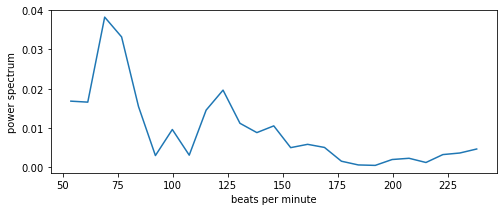

In [20]:
if __name__ == '__main__':
    main()

